In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
import os
import time
import shutil
import random
import cv2
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
print("Tensorflow version " + tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score

from mlxtend.plotting import plot_confusion_matrix

Tensorflow version 2.9.2


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Face Expression/model/fer2013/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [ ]:
data.head(5)

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [ ]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

emotion  number
0     Angry    4953
1      Fear    5121
2       Sad    6077
3   Neutral    6198
4     Happy    8989
5  Surprise    4002
6    Digust     547

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


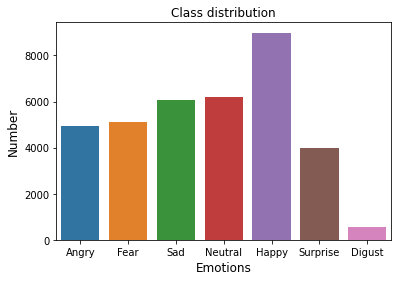

In [ ]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sn.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [ ]:
CATEGORIES = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
X = []
y = []
for index, row in data.iterrows():
    try:
        pixels=np.asarray(list(row['pixels'].split(' ')), dtype=np.uint8)
        img = pixels.reshape((48,48))
        X.append(img)
        y.append(row['emotion'])
    except Exception as e:
        pass

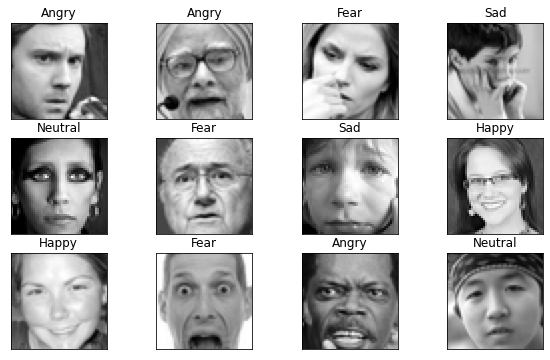

In [ ]:
fig=plt.figure(figsize=(10,6))

for counter, img in enumerate(X[:12]):
    ax = fig.add_subplot(3,4,counter+1)
    ax.imshow(X[counter], cmap='gray')
    plt.title(CATEGORIES[y[counter]])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
X = np.array(X, dtype='float32').reshape(-1, 48, 48)
rgb_X = np.repeat(X[..., np.newaxis], 3, -1)
rgb_X=rgb_X/255.
y = np.asarray(y)
y.shape

(35887,)

In [ ]:
rgb_X.shape

(35887, 48, 48, 3)

In [ ]:
(X_train, X_val, y_train, y_val) = train_test_split(rgb_X, y,
                                                    test_size=0.2,
                                                    random_state=2022,
                                                    shuffle=True,
                                                    stratify=y)

In [ ]:
X_train.shape

(28709, 48, 48, 3)

In [ ]:
X_val.shape

(7178, 48, 48, 3)

In [ ]:
aug_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

generator_val = ImageDataGenerator()

In [ ]:
aug_train.fit(X_train)

generator_val.fit(X_val)

In [ ]:
aug_train

##Resnet50

In [ ]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

In [ ]:
model = Sequential()

pretrained_model = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='imagenet')
#for layer in pretrained_model.layers:
model.trainable=False

model.add(pretrained_model)
#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
# Output layer
model.add(Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 0
Non-trainable params: 23,602,055
_________________________________________________________________


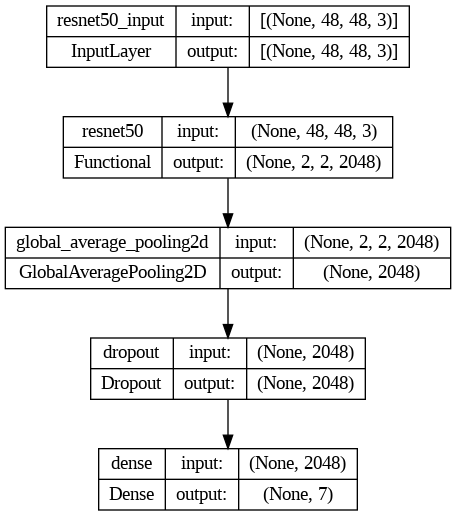

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)
#tf.keras.utils.plot_model(pretrained_model, show_shapes=True)

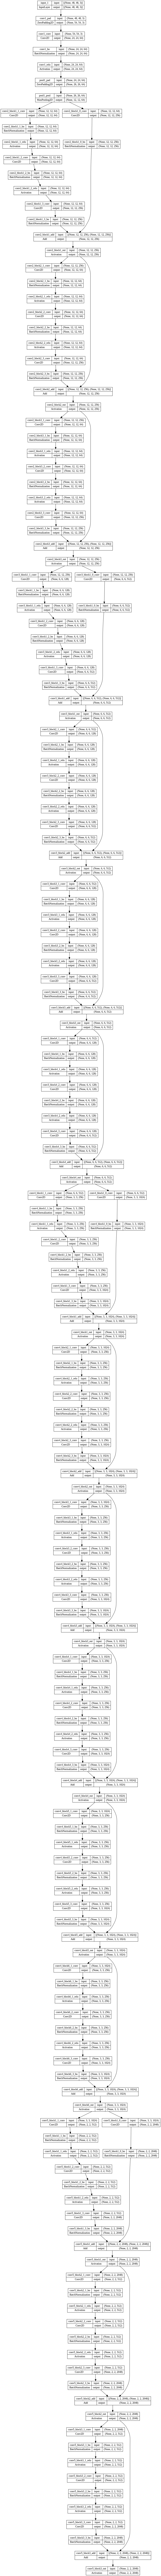

In [ ]:
tf.keras.utils.plot_model(pretrained_model, show_shapes=True)

In [ ]:
hist_path = '/content/gdrive/MyDrive/Face Expression/model/model/resnet50_2/ResNet50_Hist.log'
save_path = '/content/gdrive/MyDrive/Face Expression/model/model/resnet50_2d/ResNet50.h5'

In [ ]:
#checkpoint
checkpoint = ModelCheckpoint(
    save_path,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)
#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 7,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)
#learning_rate_schedule
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
history = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),
                    validation_data=generator_val.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(y_train) // 32,
                    epochs=50,
                    callbacks=[early_stopping, checkpoint, learning_rate_reduction, CSVLogger(hist_path)])

<ipython-input-25-ad915e7928bf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),


Epoch 1/50
897/897 [==============================] - ETA: 0s - loss: 2.8865 - accuracy: 0.1450
Epoch 1: val_accuracy improved from -inf to 0.13416, saving model to /content/gdrive/MyDrive/Face Expression/model/model/resnet50_2d/ResNet50.h5
897/897 [==============================] - 53s 48ms/step - loss: 2.8865 - accuracy: 0.1450 - val_loss: 15.1813 - val_accuracy: 0.1342 - lr: 5.0000e-04
Epoch 2/50
896/897 [============================>.] - ETA: 0s - loss: 2.8995 - accuracy: 0.1408
Epoch 2: val_accuracy improved from 0.13416 to 0.16244, saving model to /content/gdrive/MyDrive/Face Expression/model/model/resnet50_2d/ResNet50.h5
897/897 [==============================] - 36s 40ms/step - loss: 2.8994 - accuracy: 0.1408 - val_loss: 4.4774 - val_accuracy: 0.1624 - lr: 5.0000e-04
Epoch 3/50
896/897 [============================>.] - ETA: 0s - loss: 2.8893 - accuracy: 0.1450
Epoch 3: val_accuracy did not improve from 0.16244
897/897 [==============================] - 35s 39ms/step - loss: 2.

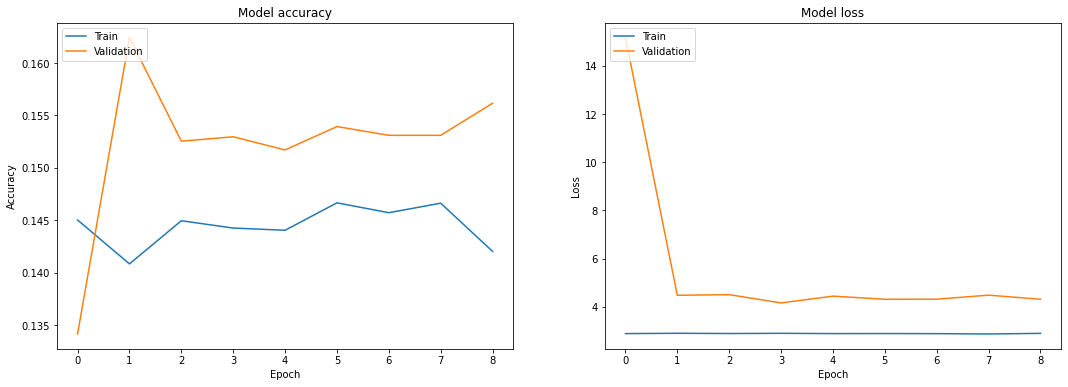

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model = Sequential()

pretrained_model = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='imagenet')
#for layer in pretrained_model.layers:
#        layer.trainable=False

model.add(pretrained_model)
#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
# Output layer
model.add(Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


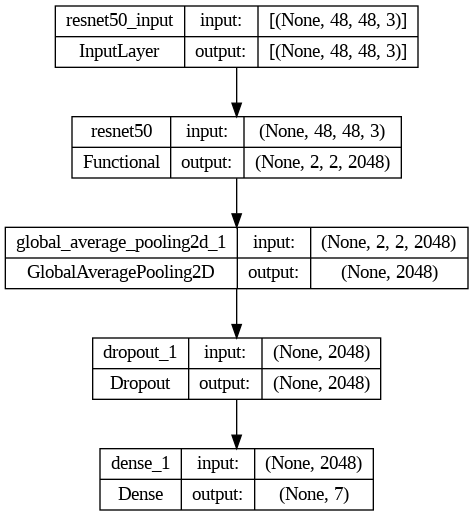

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)
#tf.keras.utils.plot_model(pretrained_model, show_shapes=True)

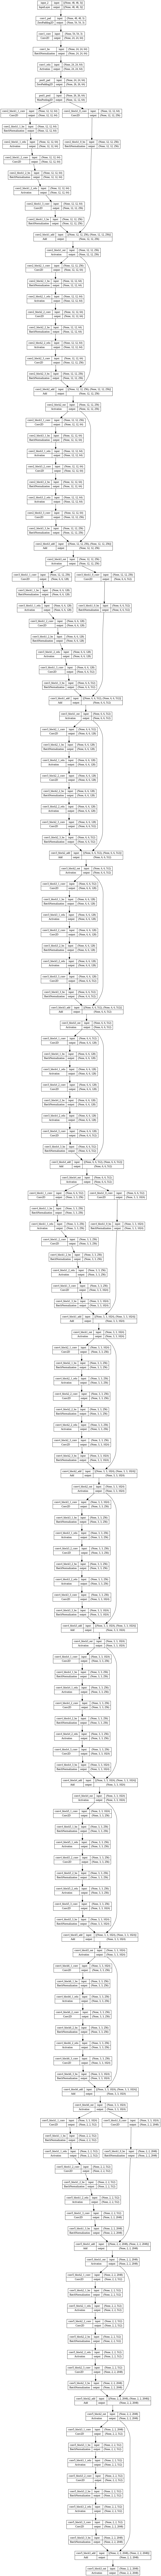

In [ ]:
tf.keras.utils.plot_model(pretrained_model, show_shapes=True)

In [ ]:
hist_path = '/content/gdrive/MyDrive/Face Expression/model/model/resnet50_2/ResNet50_Hist.log'
save_path = '/content/gdrive/MyDrive/Face Expression/model/model/resnet50_2d/ResNet50.h5'

In [ ]:
#checkpoint
checkpoint = ModelCheckpoint(
    save_path,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)
#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 7,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)
#learning_rate_schedule
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
history = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),
                    validation_data=generator_val.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(y_train) // 32,
                    epochs=50,
                    callbacks=[early_stopping, checkpoint, learning_rate_reduction, CSVLogger(hist_path)])

Epoch 1/50


<ipython-input-32-ad915e7928bf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),


897/897 [==============================] - ETA: 0s - loss: 1.7093 - accuracy: 0.3713
Epoch 1: val_accuracy improved from -inf to 0.38994, saving model to /content/gdrive/MyDrive/Face Expression/model/model/resnet50_2d/ResNet50.h5
897/897 [==============================] - 65s 65ms/step - loss: 1.7093 - accuracy: 0.3713 - val_loss: 1.6643 - val_accuracy: 0.3899 - lr: 5.0000e-04
Epoch 2/50
897/897 [==============================] - ETA: 0s - loss: 1.4174 - accuracy: 0.4651
Epoch 2: val_accuracy improved from 0.38994 to 0.47311, saving model to /content/gdrive/MyDrive/Face Expression/model/model/resnet50_2d/ResNet50.h5
897/897 [==============================] - 54s 60ms/step - loss: 1.4174 - accuracy: 0.4651 - val_loss: 1.3294 - val_accuracy: 0.4731 - lr: 5.0000e-04
Epoch 3/50
897/897 [==============================] - ETA: 0s - loss: 1.3345 - accuracy: 0.4952
Epoch 3: val_accuracy improved from 0.47311 to 0.47743, saving model to /content/gdrive/MyDrive/Face Expression/model/model/resnet

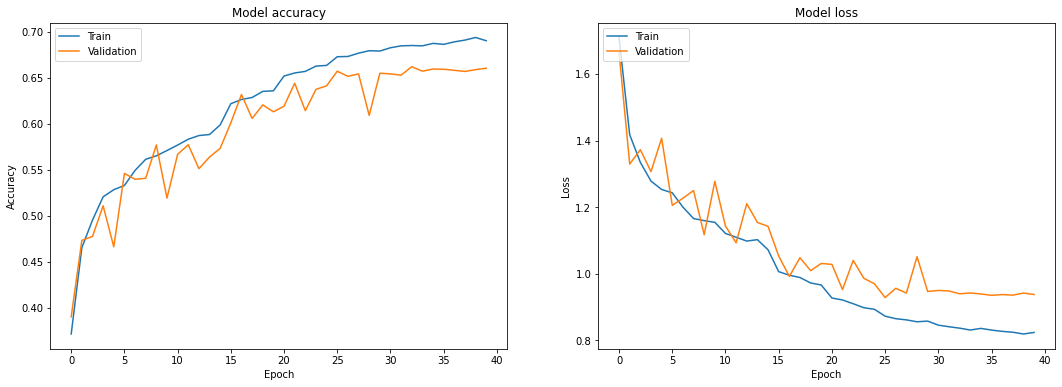

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()
